<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-data-and-model" data-toc-modified-id="Prepare-data-and-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare data and model</a></span></li><li><span><a href="#Customer-segmentation" data-toc-modified-id="Customer-segmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Customer segmentation</a></span></li><li><span><a href="#Customer-segmentation-w/-PCA-&amp;-Scaling-before-clustering" data-toc-modified-id="Customer-segmentation-w/-PCA-&amp;-Scaling-before-clustering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Customer segmentation w/ PCA &amp; Scaling before clustering</a></span></li></ul></div>

# Prepare data and model

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

import nltk
import nltk.data
nltk.download('stopwords')
from nltk.corpus import stopwords # Import the stop word list



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daviderickson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def load_reviews(size='small'): 
    if size == 'small':
        filename = r'../../data/small-review.json'
    elif size == 'intermediate':
        filename = r'../../data/intermediate-review.json'
    elif size == 'full':
        filename = r'../../data/review.json'
    new_list = []
    for line in open(filename):
       new_list.append(json.loads(line))
    return pd.DataFrame.from_records(new_list)

dfreviews = load_reviews(size='intermediate')

In [4]:
dfreviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ


In [5]:
dfreviews.columns

Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text',
       'useful', 'user_id'],
      dtype='object')

In [6]:
dfreviews['text'][0]

'Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.'

In [7]:
# For simplicity, drop anything that isn't a letter
# Numbers and symbols may have interesting meaning and could be explore later

def lettersOnly(string):
    return re.sub("[^a-zA-Z]", " ", string) 

dfreviews['text'] = dfreviews['text'].apply(lettersOnly)


In [8]:
dfreviews['text'][0]

'Total bill for this horrible service  Over   Gs  These crooks actually had the nerve to charge us     for   pills  I checked online the pills can be had for    cents EACH  Avoid Hospital ERs at all costs '

In [16]:
def review_to_wordlist(string, remove_stopwords=False):
    string = re.sub("[^a-zA-Z]", " ", string) # keep only letters. more complex model possible later
    words =  string.lower().split() # make everything lowercase. split into words
    if remove_stopwords:
        stops = set(stopwords.words('english')) # create a fast lookup for stopwords
        words = [w for w in words if not w in stops] # remove stopwords
    return( words) # return a list of words
    
# dfreviews['text'] = dfreviews['text'].apply(review_to_words) # apply to reviews in dataframe


In [17]:
# Word2Vec expects single sentences, each one as a list of words

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist( raw_sentence, \
              remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [19]:
sentences = []  # Initialize an empty list of sentences

print("Parsing sentences")
for review in dfreviews["text"]:
    sentences += review_to_sentences(review, tokenizer)

Parsing sentences


In [ ]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

In [10]:
dfreviews['text'] = dfreviews['text'].apply(review_to_words)

In [11]:
dfreviews['text'][0]

'total bill horrible service gs crooks actually nerve charge us pills checked online pills cents avoid hospital ers costs'

In [11]:
print("Creating the TFIDF...\n")
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the "TfidfVectorizer" object, which is scikit-learn's
# term frequency, inverse document frequency (TFIDF) tool.  
vectorizer = TfidfVectorizer(max_df = 0.1, min_df=15, \
                             analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 1000) # 5000

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(dfreviews['text'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

Creating the TFIDF...



In [12]:
print(train_data_features.shape)

(100000, 1000)


In [13]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print(vocab)

['able', 'absolutely', 'accommodating', 'across', 'actually', 'add', 'added', 'affordable', 'afternoon', 'ago', 'ahead', 'air', 'airport', 'almost', 'alone', 'along', 'already', 'although', 'ambiance', 'amount', 'another', 'answer', 'anyone', 'anything', 'anyway', 'anywhere', 'apparently', 'appetizer', 'appetizers', 'apple', 'appointment', 'appreciate', 'area', 'around', 'arrived', 'asian', 'ask', 'asked', 'asking', 'ate', 'atmosphere', 'attention', 'attentive', 'attitude', 'authentic', 'available', 'average', 'avocado', 'avoid', 'away', 'awesome', 'awful', 'baby', 'bacon', 'bad', 'bag', 'baked', 'bar', 'barely', 'bartender', 'based', 'basically', 'bathroom', 'bbq', 'beans', 'beautiful', 'bed', 'beef', 'beer', 'beers', 'behind', 'believe', 'better', 'beyond', 'big', 'bill', 'birthday', 'bit', 'bite', 'black', 'bland', 'blue', 'book', 'bottle', 'bottom', 'bought', 'bowl', 'box', 'boyfriend', 'bread', 'breakfast', 'bring', 'brisket', 'brought', 'brunch', 'bucks', 'buffet', 'building', 'b

# Customer segmentation

In [14]:
# train_data_features has tfidf featues
# Add other data to each review (stars, useful, ...)
# GroupBy User and avg across each review
# Cluster users using K-means
# Interpret user clusters


# Add non-text data back to feature matrix
review_features = ['cool', 'funny', 'stars', 'useful', 'user_id']
all_features_labels = vectorizer.get_feature_names() + review_features
all_features = np.append(train_data_features, dfreviews[review_features].to_numpy(), 1)


In [15]:
# GroupBy User and avg across each review
all_features_df = pd.DataFrame(data=all_features, columns=all_features_labels)
all_features_df_tmp = all_features_df.iloc[:,:-1].astype('float64')
all_features_df_tmp['user_id'] = all_features_df['user_id']
all_features_df = all_features_df_tmp
del all_features_df_tmp
all_features_User = all_features_df.groupby(by='user_id').mean()

In [16]:
all_features_User.head()

,able,absolutely,accommodating,across,actually,add,added,affordable,afternoon,ago,...,yelp,yes,yet,young,yum,yummy,cool,funny,stars,useful
user_id,,,,,,,,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,2.5
--2HUmLkcNHZp0xw6AMBPg,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0
--3WaS23LcIXtxyFULJHTA,0.0,0.0,0.0,0.0,0.0,0.148205,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,4.0
--7oh57FmI8_IHX0Q4n-Wg,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0
--HCoE1ghaAlcaAfshICgw,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


In [17]:
# Cluster users using K-means
from sklearn.cluster import KMeans

max_clusters = 10
kmeans_cost = []
for num_clusters in range(1,max_clusters):
    k_means_clutering = KMeans(n_clusters=num_clusters)
    k_means_clutering.fit(all_features_User)
    kmeans_cost.append(k_means_clutering.inertia_)
    

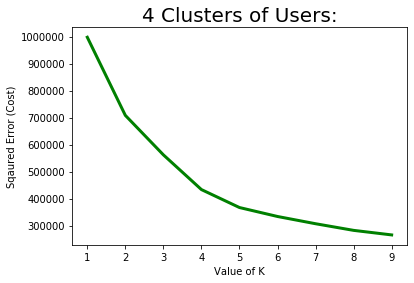

In [18]:
# Determine the best value of K to use (the number of clusters)
# plot the cost against K values 
plt.plot(range(1, max_clusters), kmeans_cost, color ='g', linewidth ='3') 
plt.title('4 Clusters of Users:', fontsize=20)
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

In [19]:
# Cluster users using K-means
# Interpret user clusters

num_clusters = 4
k_means_clutering = KMeans(n_clusters=num_clusters)
k_means_clutering.fit(all_features_User)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [20]:
user_cluster_centers_df = pd.DataFrame(data=k_means_clutering.cluster_centers_, columns=all_features_User.columns)
user_cluster_centers_df.head()

,able,absolutely,accommodating,across,actually,add,added,affordable,afternoon,ago,...,yelp,yes,yet,young,yum,yummy,cool,funny,stars,useful
0,0.003965,0.004737,0.000869,0.003158,0.007645,0.003382,0.002445,0.000637,0.001931,0.005017,...,0.003827,0.003934,0.004626,0.002603,0.000707,0.001364,0.152420,0.298753,1.858322,0.889407
1,0.007130,0.006334,0.001361,0.005311,0.008616,0.009217,0.003428,0.003955,0.000474,0.009419,...,0.028259,0.014017,0.012318,0.003610,0.014593,0.006009,27.601936,18.927970,3.742930,34.878565
2,0.006127,0.008275,0.003746,0.002739,0.004827,0.002873,0.002300,0.003461,0.002035,0.003686,...,0.004216,0.003051,0.003768,0.001680,0.002986,0.006125,0.267399,0.149440,4.661821,0.589344
3,0.007919,0.007250,0.001601,0.004256,0.010875,0.004993,0.003295,0.002453,0.002782,0.006199,...,0.008401,0.006825,0.006756,0.003259,0.001928,0.003197,2.608094,2.433545,3.139903,7.492422


In [21]:
user_cluster_centers_df.iloc[0].to_dict()

{'able': 0.0039648040073260735,
 'absolutely': 0.004736782013237368,
 'accommodating': 0.0008686171623526486,
 'across': 0.0031584860628434057,
 'actually': 0.007644811449774448,
 'add': 0.003382496845152867,
 'added': 0.002444957402918013,
 'affordable': 0.0006365839876511306,
 'afternoon': 0.0019305504685751323,
 'ago': 0.005017016466129288,
 'ahead': 0.002362911338151568,
 'air': 0.0023120918045201355,
 'airport': 0.0029663974797335914,
 'almost': 0.007524044478896963,
 'alone': 0.0017201227402212232,
 'along': 0.002231129885555347,
 'already': 0.005069588778148814,
 'although': 0.003912142615867522,
 'ambiance': 0.0020755535696811707,
 'amount': 0.003841484025451128,
 'another': 0.015056108064175892,
 'answer': 0.0027762993568234287,
 'anyone': 0.0053063311086562785,
 'anything': 0.009320015163260706,
 'anyway': 0.002486178115349605,
 'anywhere': 0.00231734670704303,
 'apparently': 0.0031555012350079382,
 'appetizer': 0.0030945259357535375,
 'appetizers': 0.002239404535137251,
 'ap

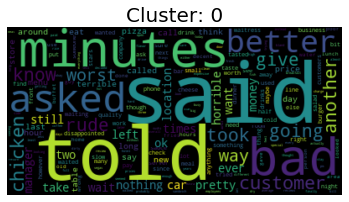

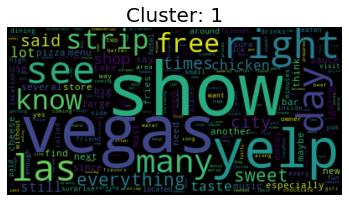

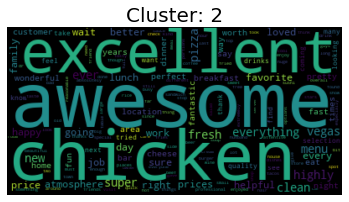

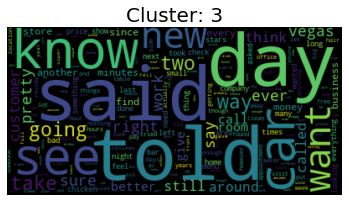

In [22]:
from wordcloud import WordCloud

for cluster in range(len(user_cluster_centers_df)):
    series = user_cluster_centers_df.iloc[cluster,:-4] #Use relevant row, drop non-word cols
    wc_dict = series.to_dict()
    wordcloud = WordCloud().generate_from_frequencies(wc_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Cluster: {}'.format(cluster), fontsize=20)
    plt.axis('off')
    plt.show()
    

# Customer segmentation w/ PCA & Scaling before clustering

In [23]:
# Min Max Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# PCA all_features_User
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaler.fit_transform(all_features_User))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

(0, 500)

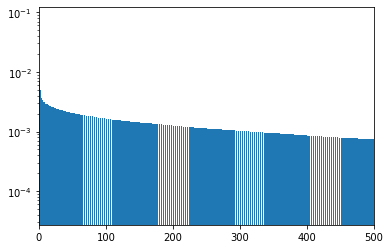

In [24]:
plt.bar(x=range(len(pca.explained_variance_ratio_)), height=pca.explained_variance_ratio_, log=True)
plt.xlim((0,500))

In [25]:
pca = PCA(n_components=200)
pca_user_features = pca.fit_transform(all_features_User)

In [26]:
# Cluster users using K-means
from sklearn.cluster import KMeans

max_clusters = 10
kmeans_cost = []
for num_clusters in range(1,max_clusters):
    k_means_clutering = KMeans(n_clusters=num_clusters)
    k_means_clutering.fit(pca_user_features)
    kmeans_cost.append(k_means_clutering.inertia_)
    

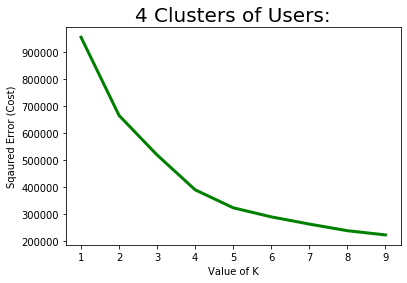

In [27]:
# Determine the best value of K to use (the number of clusters)
# plot the cost against K values 
plt.plot(range(1, max_clusters), kmeans_cost, color ='g', linewidth ='3') 
plt.title('4 Clusters of Users:', fontsize=20)
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

In [28]:
# Cluster users using K-means
# Interpret user clusters

num_clusters = 4
k_means_clutering = KMeans(n_clusters=num_clusters)
k_means_clutering.fit(pca_user_features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [29]:
# Find the center of each cluster and report 

pca_user_cluster_centers_df = all_features_User.copy()
pca_user_cluster_centers_df['cluster'] = k_means_clutering.labels_ #Add cluster label
pca_user_cluster_centers_df = pca_user_cluster_centers_df.groupby(by='cluster').mean()
pca_user_cluster_centers_df.head()

,able,absolutely,accommodating,across,actually,add,added,affordable,afternoon,ago,...,yelp,yes,yet,young,yum,yummy,cool,funny,stars,useful
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.006127,0.008275,0.003746,0.002739,0.004827,0.002873,0.002300,0.003461,0.002035,0.003686,...,0.004216,0.003051,0.003768,0.001680,0.002986,0.006125,0.267399,0.149440,4.661821,0.589344
1,0.007919,0.007250,0.001601,0.004256,0.010875,0.004993,0.003295,0.002453,0.002782,0.006199,...,0.008401,0.006825,0.006756,0.003259,0.001928,0.003197,2.608094,2.433545,3.139903,7.492422
2,0.007130,0.006334,0.001361,0.005311,0.008616,0.009217,0.003428,0.003955,0.000474,0.009419,...,0.028259,0.014017,0.012318,0.003610,0.014593,0.006009,27.601936,18.927970,3.742930,34.878565
3,0.003965,0.004737,0.000869,0.003158,0.007645,0.003382,0.002445,0.000637,0.001931,0.005017,...,0.003827,0.003934,0.004626,0.002603,0.000707,0.001364,0.152420,0.298753,1.858322,0.889407


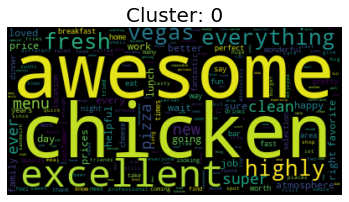

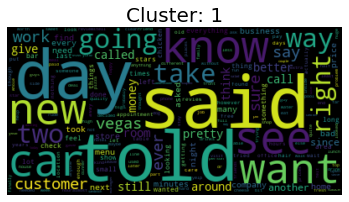

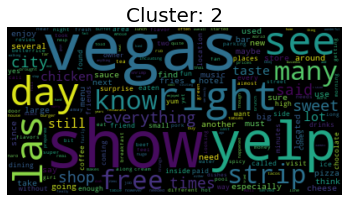

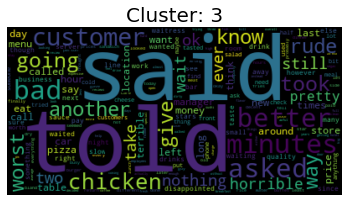

In [30]:
from wordcloud import WordCloud

for cluster in range(len(pca_user_cluster_centers_df)):
    series = pca_user_cluster_centers_df.iloc[cluster,:-4] #Use relevant row, drop non-word cols
    wc_dict = series.to_dict()
    wordcloud = WordCloud().generate_from_frequencies(wc_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Cluster: {}'.format(cluster), fontsize=20)
    plt.axis('off')
    plt.show()
    